In [1]:
%%time
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy.stats import norm, skew
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

%matplotlib inline

Wall time: 12.9 s


In [2]:
%%time
dic = np.load('data/dictionary.npy')
print(dic.item().keys())

dict_keys(['density_top_100', 'density_tail_100', 'target', 'log_features', 'vanilla'])
Wall time: 4.73 s


In [3]:
%%time

_vanilla_features = dic.item().get('vanilla')
_density_top_100_feature_names = dic.item().get('density_top_100')
_density_tail_100_feature_names = dic.item().get('density_tail_100')
_log_features = dic.item().get('log_features')
_target = dic.item().get('target')

print("_vanilla_features", _vanilla_features.shape)
print("_density_top_100_feature_names", _density_top_100_feature_names.shape) # feature names only!
print("_density_tail_100_feature_names", _density_tail_100_feature_names.shape) # feature names only!
print("_log_features", _log_features.shape)
print("_target", _target.shape)

_vanilla_features (200000,)
_density_top_100_feature_names (100,)
_density_tail_100_feature_names (100,)
_log_features (200000,)
_target (200000,)
Wall time: 498 µs


In [4]:
density_top_100_feature_names = list(_density_top_100_feature_names['feature'])
density_tail_100_feature_names = list(_density_tail_100_feature_names['feature'])

### Column names

In [5]:
vanilla_feature_names = list(_vanilla_features.dtype.names)
log_features_names = list(_log_features.dtype.names)

### Features - all features

In [6]:
vanilla_features = pd.DataFrame(_vanilla_features.astype(_vanilla_features.dtype).view('<f8').reshape(_vanilla_features.shape[0], -1), columns=vanilla_feature_names)
print(vanilla_features.shape)

(200000, 200)


### Features - log features

In [7]:
log_features = pd.DataFrame(_log_features.astype(_log_features.dtype).view('<f8').reshape(_log_features.shape[0], -1), columns=log_features_names)
print(log_features.shape)

(200000, 69)


### Target

In [8]:
target = _target.astype('int64').reshape(_target.shape[0], -1)
print(target.shape)

(200000, 1)


### Split dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def split_dataset(features, target):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=15)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=15)

    x_train = np.float64(x_train)
    x_val = np.float64(x_val)
    x_test = np.float64(x_test)

    print("Shape of x_train:", x_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of x_val:", x_val.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    print("Shape of y_val:", y_val.shape)
    
    return x_train, x_test, x_val, y_train, y_test, y_val

### Vanilla features

In [11]:
%%time
x_train, x_test, x_val, y_train, y_test, y_val = split_dataset(features=vanilla_features, target=target)

Shape of x_train: (144000, 200)
Shape of x_test: (40000, 200)
Shape of x_val: (16000, 200)
Shape of y_train: (144000, 1)
Shape of y_test: (40000, 1)
Shape of y_val: (16000, 1)
Wall time: 1.25 s


### Top 100 density features

In [12]:
%%time
#x_train, x_test, x_val, y_train, y_test, y_val = split_dataset(features=vanilla_features[density_top_100_feature_names], target=target)

Wall time: 0 ns


### Tail 100 density features

In [13]:
%%time
#x_train, x_test, x_val, y_train, y_test, y_val = split_dataset(features=vanilla_features[density_tail_100_feature_names], target=target)

Wall time: 0 ns


### Log transformation feature

In [14]:
%%time
#x_train, x_test, x_val, y_train, y_test, y_val = split_dataset(features=log_features, target=target)

Wall time: 0 ns


### ElasticNetCV

In [15]:
%%time
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=5, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)
               
cv_model.fit(x_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00000013
Optimal l1_ratio: 0.500
Number of iterations 5
Wall time: 1min 15s


### Model Evaluation

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
%%time
y_train_pred = cv_model.predict(x_train)
y_pred = cv_model.predict(x_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  -3.608980682833873
Test r2 score:  0.18576501448223948
Train RMSE: 0.2719
Test RMSE: 0.2722
Wall time: 799 ms


Train r2 score:  -3.608980682833873
Test r2 score:  0.18576501448223948
Train RMSE: 0.2719
Test RMSE: 0.2722
Wall time: 522 ms

In [18]:
vanilla_features.columns

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

### Feature importance

Index(['var_68', 'var_12', 'var_148', 'var_108', 'var_91'], dtype='object')


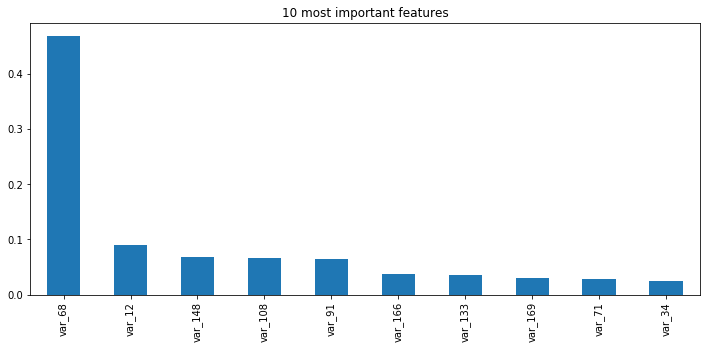

Wall time: 712 ms


In [19]:
%%time
feature_importance = pd.DataFrame(index = vanilla_features.columns, data = np.abs(cv_model.coef_)).sort_values(by=0, ascending=False)
five_important_features = feature_importance[feature_importance.values > 0.05].index

print(five_important_features)

feature_importance[:10].plot(kind = 'bar', figsize = (12,5), title="10 most important features", legend=None)
plt.show()

## Xgboost with cross-validation

In [20]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn import cross_validation

import xgboost as xgb

#### Prepare datasets

Using top 50 high density features resulted in lower AUC score - 0.77
Using top 100 high density features resulted in lower AUC score - 0.815

Using top 100 low density features resulted in lower AUC score - 0.72

In [35]:
%%time
x_train, x_test, y_train, y_test = train_test_split(vanilla_features, target, test_size=0.2, random_state=15)
#x_train, x_test, y_train, y_test = train_test_split(log_features, target, test_size=0.2, random_state=15)
#x_train, x_test, y_train, y_test = train_test_split(df[feature_low_density], target, test_size=0.2, random_state=15)
#x_train, x_test, y_train, y_test = train_test_split(df[feature_names], target, test_size=0.2, random_state=15)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=15)

x_train = np.float64(x_train)
x_val = np.float64(x_val)
x_test = np.float64(x_test)

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (144000, 200)
y_train (144000, 1)
x_test (40000, 200)
y_test (40000, 1)
Wall time: 6.27 s


### Default model

In [36]:
%%time
xgb_model1 = XGBClassifier(max_depth = 7,
                n_estimators=50,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301,
                silent=0)
xgb_model1.fit(x_train, y_train, verbose=True)

# learning_rate = 0.05 - 0.075, 0.1, max_depth 5-10
# use grid!
# logistic regression

Wall time: 1min 26s


In [37]:
xgb_model1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=3, missing=None, n_estimators=50,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1301, silent=0,
       subsample=1.0)

In [38]:
%%time
y_pro1 = xgb_model1.predict_proba(x_test)[:, 1]
print("AUC Score :", roc_auc_score(y_test, y_pro1))

AUC Score : 0.8310632285174782
Wall time: 409 ms


In [39]:
# AUC Score : 0.8305487410546821 - n_estimators=50

#### cross validation

In [26]:
%%time
xgtrain = xgb.DMatrix(x_train, label=y_train)
xgb_model1_param = xgb_model1.get_params()
cvresult = xgb.cv(params=xgb_model1_param, dtrain=xgtrain, num_boost_round=200, nfold=5, metrics=['auc'],
                  early_stopping_rounds=5, stratified=True, seed=0, verbose_eval=True)

[0]	train-auc:0.623579+0.000566038	test-auc:0.613507+0.00126284
[1]	train-auc:0.679222+0.00985164	test-auc:0.661106+0.00933572
[2]	train-auc:0.705092+0.00476825	test-auc:0.681848+0.00792949
[3]	train-auc:0.719461+0.00499575	test-auc:0.693367+0.006589
[4]	train-auc:0.729089+0.00532274	test-auc:0.700509+0.00337313
[5]	train-auc:0.737158+0.00432681	test-auc:0.704879+0.00462451
[6]	train-auc:0.742504+0.00334134	test-auc:0.708399+0.00442376
[7]	train-auc:0.746172+0.00445579	test-auc:0.709795+0.00466132
[8]	train-auc:0.75027+0.00561661	test-auc:0.712654+0.00525394
[9]	train-auc:0.754691+0.00490892	test-auc:0.715615+0.00495047
[10]	train-auc:0.758177+0.00471668	test-auc:0.717584+0.00569034
[11]	train-auc:0.761361+0.00452969	test-auc:0.719544+0.00513962
[12]	train-auc:0.765227+0.00352935	test-auc:0.721923+0.00546159
[13]	train-auc:0.767825+0.00289048	test-auc:0.723603+0.00629918
[14]	train-auc:0.771111+0.00309023	test-auc:0.725293+0.00592906
[15]	train-auc:0.773993+0.00337755	test-auc:0.726117

[129]	train-auc:0.924653+0.000834787	test-auc:0.774384+0.00465854
[130]	train-auc:0.925098+0.000812119	test-auc:0.774527+0.00455217
[131]	train-auc:0.92551+0.00084832	test-auc:0.774557+0.00451367
[132]	train-auc:0.925979+0.000813946	test-auc:0.774568+0.00444679
[133]	train-auc:0.926361+0.000801811	test-auc:0.77463+0.00448245
[134]	train-auc:0.926778+0.000767005	test-auc:0.774632+0.00447718
[135]	train-auc:0.927241+0.000920655	test-auc:0.774595+0.00449313
[136]	train-auc:0.92762+0.000999741	test-auc:0.774597+0.00452209
[137]	train-auc:0.928122+0.00105796	test-auc:0.774694+0.0045243
[138]	train-auc:0.928537+0.00101119	test-auc:0.774781+0.0045724
[139]	train-auc:0.928916+0.000938408	test-auc:0.774765+0.00459031
[140]	train-auc:0.929415+0.000934706	test-auc:0.774737+0.0046279
[141]	train-auc:0.929813+0.000966676	test-auc:0.774773+0.00466416
[142]	train-auc:0.930318+0.000966299	test-auc:0.774791+0.00462915
[143]	train-auc:0.930637+0.000978163	test-auc:0.774808+0.00467181
[144]	train-auc:0.9

In [40]:
#test-auc:0.871584+0.00182564 - num_boost_round=200, nfold=5

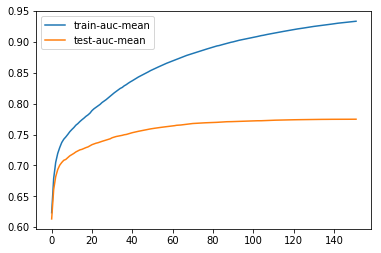

In [41]:
cvresult[['train-auc-mean', 'test-auc-mean']].plot()

### Tweaking hypeparameters

In [42]:
#x_train.shape #(160000, 69)
x_val.shape

(16000, 200)

In [43]:
%%time
xgb_model2 = XGBClassifier(max_depth=20,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=1000,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)

xgb_model2.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=5, verbose=True)

[0]	validation_0-error:0.126937
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.125938
[2]	validation_0-error:0.106188
[3]	validation_0-error:0.105812
[4]	validation_0-error:0.100875
[5]	validation_0-error:0.101187
[6]	validation_0-error:0.100188
[7]	validation_0-error:0.100375
[8]	validation_0-error:0.099188
[9]	validation_0-error:0.09875
[10]	validation_0-error:0.098937
[11]	validation_0-error:0.098625
[12]	validation_0-error:0.099188
[13]	validation_0-error:0.098687
[14]	validation_0-error:0.098563
[15]	validation_0-error:0.098312
[16]	validation_0-error:0.098438
[17]	validation_0-error:0.09825
[18]	validation_0-error:0.098563
[19]	validation_0-error:0.098375
[20]	validation_0-error:0.09825
[21]	validation_0-error:0.098375
[22]	validation_0-error:0.098438
Stopping. Best iteration:
[17]	validation_0-error:0.09825

Wall time: 11min 31s


In [45]:
%%time

#y_pre2 = xgb_model2.predict(x_test)
y_pro2 = xgb_model2.predict_proba(x_test)[:, 1]
print("AUC Score :", roc_auc_score(y_test, y_pro2))
#print("Accuracy :", accuracy_score(y_test, y_pre2))

AUC Score : 0.7747907790239524
Wall time: 658 ms


Metric **accuracy** is not relevant in this case, AUC is.

## Running without most important feature

In [46]:
#mif = 'var_68' # most important feature

In [47]:
#feature_names_without_mif = [f for f in vanilla_features.columns if f != mif] #list comprehension

In [49]:
%%time
#x_train, x_test, y_train, y_test = train_test_split(df[feature_names_without_mif], target, test_size=0.2, random_state=15)
#x_train, x_test, y_train, y_test = train_test_split(df[feature_names], target, test_size=0.2, random_state=15)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=15)

#x_train = np.float64(x_train)
#x_val = np.float64(x_val)
#x_test = np.float64(x_test)

Wall time: 0 ns


In [50]:
%%time
xgb_model_no_wif = XGBClassifier()

xgb_model_no_wif.fit(x_train, y_train, verbose=True)

Wall time: 5min 18s


In [51]:
%%time
y_pro1 = xgb_model_no_wif.predict_proba(x_test)[:, 1]
print("AUC Score :", roc_auc_score(y_test, y_pro1))

AUC Score : 0.8369446714533239
Wall time: 693 ms


## Regression

In [53]:
%%time
xgb_model_reg = XGBRegressor(max_depth=20,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=10, #1000,
                           silent=True,
                           #objective='binary:logistic',
                           objective='reg:linear',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
xgb_model_reg.fit(x_train, y_train, verbose=True)

Wall time: 3min 36s


In [54]:
xgb_model_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [55]:
y_prob_reg = xgb_model_reg.predict(x_test)

In [56]:
%%time
print("AUC Score :", roc_auc_score(y_test, y_prob_reg))

AUC Score : 0.7324460736118261
Wall time: 17.5 ms


In [58]:
#xgb_model_reg_param = xgb_model_reg.get_params
#cvresult = xgb_model_reg.cv(xgb_param, x_train, num_boost_round=5000, nfold=5, metrics=['auc'], 
#                  early_stopping_rounds=50, stratified=True, seed=1301)

## Submission of results

In [ ]:
import time

def submit_results(model):
    test = pd.read_csv("data/test.csv")
    print(test.shape)
    
    test_features = test.drop(['ID_code'], axis=1)
    result_df = pd.DataFrame(test["ID_code"])

    print("test_features shape", test_features.shape)
    print("result_df shape", result_df.shape)
    
    array = np.array(test_features)
    
    result_df['one'] = model.predict_proba(array)[:, 1]
    
    print(result_df[result_df['one'] > 0.5]['one'].value_counts().sum()/result_df.shape[0]*100, '\b%')

    t = time.localtime()
    timestamp = time.strftime('%Y%m%d_%H%M', t)
    save_filename = ("score/xgboost_result-" + timestamp + ".csv")

    result_df = result_df.rename(columns={'one': 'target'}) # rename to match submission criteria
    result_df[['ID_code', 'target']].to_csv(save_filename, index=False)
    
    print("Submission file is ready:", save_filename)

In [ ]:
%%time
submit_results(model=xgb_model1)